In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os, yaml
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from msfm.utils import files

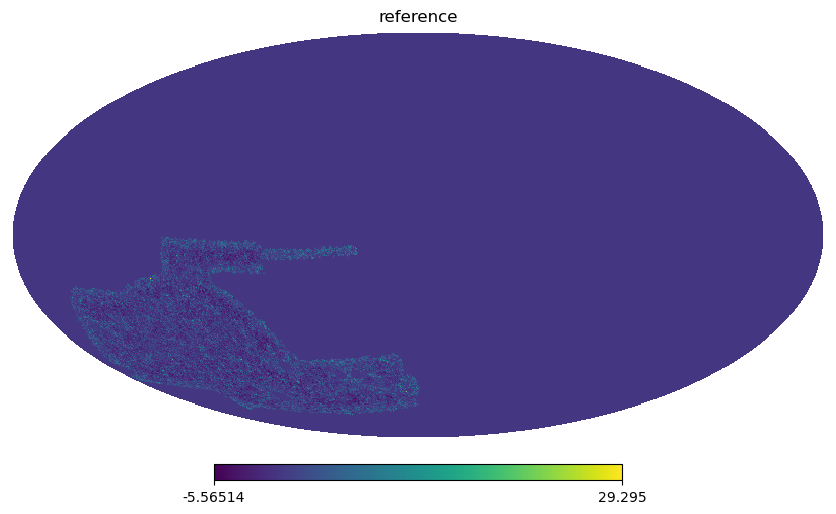

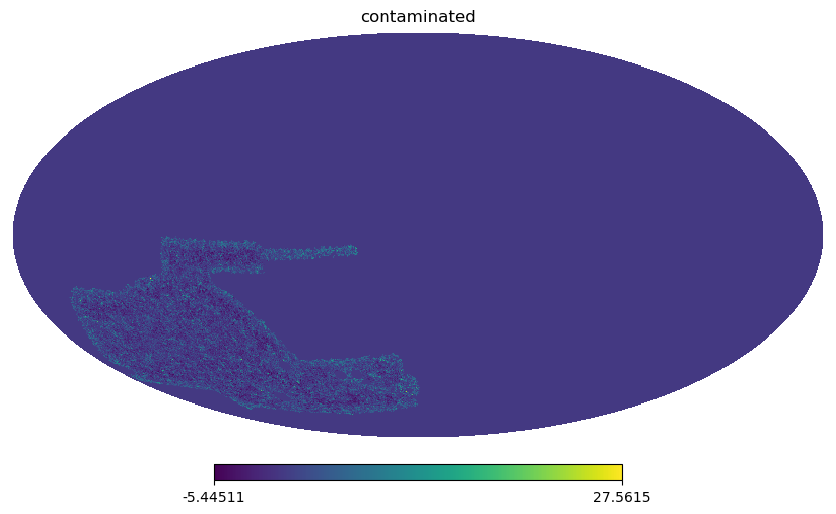

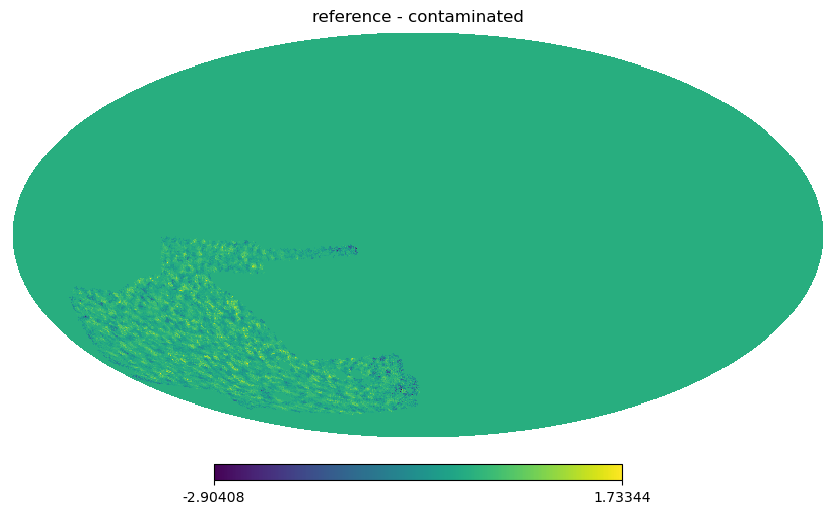

In [3]:
obs_dir = "/pscratch/sd/a/athomsen/v11desy3/v14/extended/obs"
with h5py.File(os.path.join(obs_dir, "fiducial_bench_obs_maps_survey_ref_noiseless_0000.h5"), "r") as f:
    ref_dv = f["obs/maps"][:]
    
with h5py.File(os.path.join(obs_dir, "fiducial_bench_obs_maps_survey_sys_noiseless_0000.h5"), "r") as f:
    sys_dv = f["obs/maps"][:]

msfm_conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v15/extended.yaml")
data_vec_pix, _, _, _ = files.load_pixel_file(msfm_conf)
n_pix = msfm_conf["analysis"]["n_pix"]

i_patch = 0
i_z = -1

ref_map = np.zeros(n_pix)
ref_map[data_vec_pix] = ref_dv[i_patch,:,i_z]
hp.mollview(ref_map, nest=True, title="reference")

sys_map = np.zeros(n_pix)
sys_map[data_vec_pix] = sys_dv[i_patch,:,i_z]
hp.mollview(sys_map, nest=True, title="contaminated")

diff_map = ref_map - sys_map
hp.mollview(diff_map, nest=True, title="reference - contaminated")

# ratio_map = np.zeros_like(ref_map)
# ratio_map[ref_map!=0] = ref_map[ref_map!=0] / sys_map[sys_map!=0]
# hp.mollview(ratio_map, nest=True, title="reference / contaminated")

In [4]:
from deep_lss.utils import configuration
from msfm.utils import scales

In [5]:
model_dir = "/pscratch/sd/a/athomsen/run_files/v14/extended/clustering/mutual_info/2025-05-14_23-10-45_deepsphere_default"

with open(os.path.join(model_dir, "configs.yaml"), "r") as f:
    net_conf, dlss_conf, msfm_conf = list(yaml.load_all(f, Loader=yaml.FullLoader))
data_vec_pix = files.load_pixel_file(msfm_conf)[0]

smoothing_kwargs = configuration.get_smoothing_kwargs(
    net_conf["run"]["loss_func"], msfm_conf, dlss_conf, net_conf, dir_base="."
)

print(smoothing_kwargs)

{'nside': 512, 'indices': array([1119232, 1119233, 1119234, ..., 2955261, 2955262, 2955263],
      dtype=int32), 'nest': True, 'mask': array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       ...,
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int32), 'fwhm': [130.2, 88.9, 68.1, 57.0], 'arcmin': True, 'n_sigma_support': 3, 'max_batch_size': 16, 'white_noise_sigma': array([0.85135, 0.34375, 0.25989, 0.24127]), 'data_path': './smoothing'}


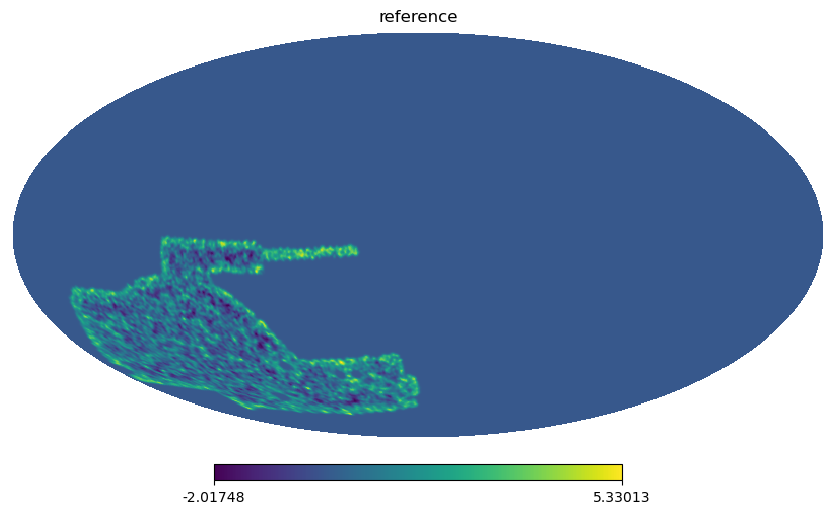

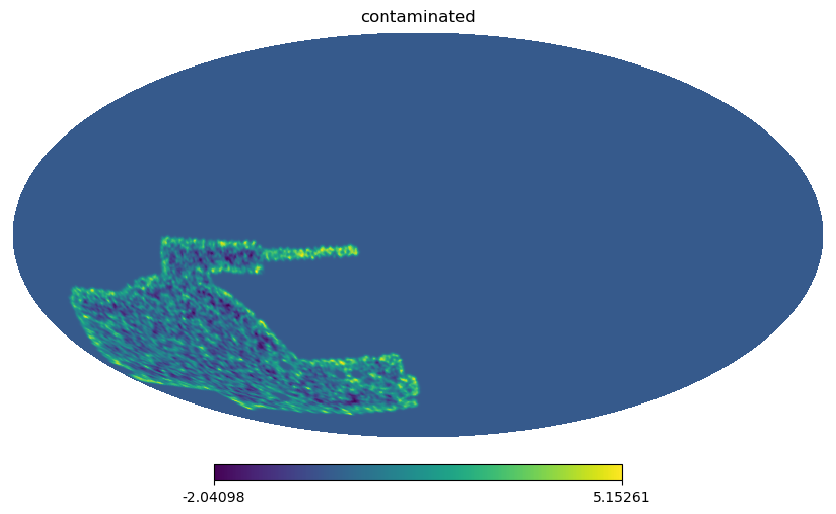

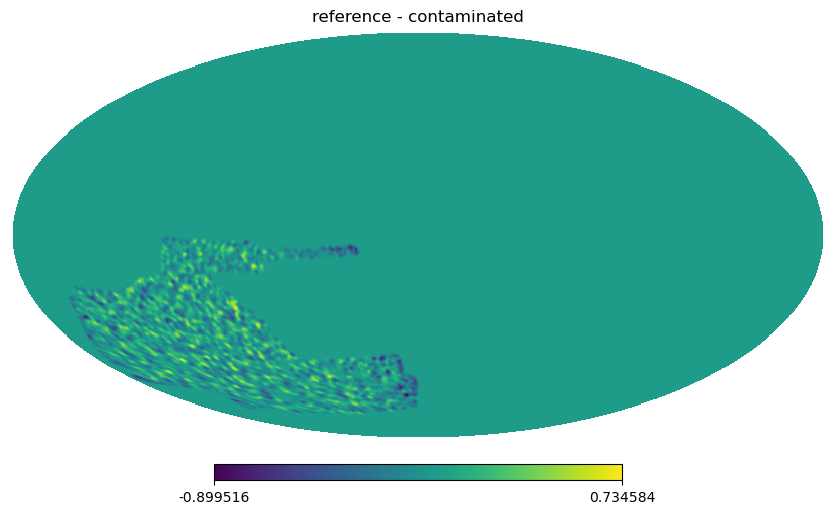

In [6]:
obs_dir = "/pscratch/sd/a/athomsen/v11desy3/v14/extended/obs"
with h5py.File(os.path.join(obs_dir, "fiducial_bench_obs_maps_survey_ref_noiseless_0000.h5"), "r") as f:
    ref_dv = f["obs/maps"][:]
    
with h5py.File(os.path.join(obs_dir, "fiducial_bench_obs_maps_survey_sys_noiseless_0000.h5"), "r") as f:
    sys_dv = f["obs/maps"][:]

i_patch = 0
i_z = -1

def smooth_map(hp_map):
    return scales.map_to_smoothed_map(
        hp_map,
        n_side=512,
        theta_fwhm=smoothing_kwargs["fwhm"][i_z],
        arcmin=True,
        nest=True,
        conf=msfm_conf,
    )[0]

ref_map = np.zeros(n_pix)
ref_map[data_vec_pix] = ref_dv[i_patch,:,i_z]
ref_map = smooth_map(ref_map)
hp.mollview(ref_map, nest=True, title="reference")

sys_map = np.zeros(n_pix)
sys_map[data_vec_pix] = sys_dv[i_patch,:,i_z]
sys_map = smooth_map(sys_map)
hp.mollview(sys_map, nest=True, title="contaminated")

diff_map = ref_map - sys_map
hp.mollview(diff_map, nest=True, title="reference - contaminated")